In [1]:
# First, install required packages
!pip install folium

# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import random
from typing import List, Tuple
import folium
from IPython.display import display, HTML, clear_output

# Step 1: Define our Moroccan cities
We'll use actual coordinates of major Moroccan cities

In [4]:
# Define Moroccan cities with their coordinates (latitude, longitude) and names
CITIES = [
    {"name": "Casablanca", "coords": [33.5731, -7.5898]},
    {"name": "Rabat", "coords": [34.0209, -6.8416]},
    {"name": "Fes", "coords": [34.0181, -5.0078]},
    {"name": "Marrakech", "coords": [31.6295, -7.9811]},
    {"name": "Tangier", "coords": [35.7595, -5.8340]},
    {"name": "Agadir", "coords": [30.4278, -9.5981]},
    {"name": "Meknes", "coords": [33.8935, -5.5547]},
    {"name": "Oujda", "coords": [34.6867, -1.9114]},
    {"name": "Kenitra", "coords": [34.2610, -6.5802]},
    {"name": "Tetouan", "coords": [35.5889, -5.3626]}
    ]


# Step 2: Define our classes and helper functions

In [5]:
# GA Parameters
POPULATION_SIZE = 100
MAX_GENERATIONS = 200
MUTATION_RATE = 0.2
TOURNAMENT_SIZE = 5

class City:
    def __init__(self, name: str, lat: float, lon: float):
        self.name = name
        self.lat = lat
        self.lon = lon

class Route:
    def __init__(self):
        self.path = []
        self.fitness = float('inf')

    def calculate_fitness(self) -> float:
        total_distance = 0
        for i in range(len(self.path)):
            city1 = self.path[i]
            city2 = self.path[(i + 1) % len(self.path)]
            total_distance += haversine_distance(city1, city2)
        self.fitness = total_distance
        return self.fitness

# Step 3: Implement distance calculation using Haversine formula

In [6]:
def haversine_distance(city1: City, city2: City) -> float:
    """Calculate the great circle distance between two cities"""
    R = 6371  # Earth's radius in kilometers

    lat1, lon1 = np.radians(city1.lat), np.radians(city1.lon)
    lat2, lon2 = np.radians(city2.lat), np.radians(city2.lon)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c

# Step 4: Implement Genetic Algorithm Functions


In [7]:
def create_initial_population(cities: List[City], pop_size: int) -> List[Route]:
    """Create initial random population"""
    population = []
    for _ in range(pop_size):
        route = Route()
        route.path = random.sample(cities, len(cities))
        route.calculate_fitness()
        population.append(route)
    return population

def tournament_selection(population: List[Route]) -> Route:
    """Select parent using tournament selection"""
    tournament = random.sample(population, TOURNAMENT_SIZE)
    return min(tournament, key=lambda x: x.fitness)

def ordered_crossover(parent1: Route, parent2: Route) -> Route:
    """Create child route using ordered crossover"""
    size = len(parent1.path)
    child = Route()
    child.path = [None] * size

    start = random.randint(0, size-2)
    end = random.randint(start+1, size-1)

    child.path[start:end+1] = parent1.path[start:end+1]

    parent2_cities = [city for city in parent2.path if city not in child.path[start:end+1]]
    j = 0
    for i in range(size):
        if child.path[i] is None:
            child.path[i] = parent2_cities[j]
            j += 1

    child.calculate_fitness()
    return child

def swap_mutation(route: Route) -> None:
    """Perform swap mutation"""
    if random.random() < MUTATION_RATE:
        i, j = random.sample(range(len(route.path)), 2)
        route.path[i], route.path[j] = route.path[j], route.path[i]
        route.calculate_fitness()

# Step 5: Implement Visualization Functions

> Add blockquote



In [8]:
def plot_fitness_progress(fitness_history: List[float]):
    """Plot the fitness progress over generations"""
    plt.figure(figsize=(10, 5))
    plt.plot(fitness_history, 'b-')
    plt.title('Best Fitness Over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Distance (km)')
    plt.grid(True)
    plt.show()

def create_route_map(best_route: Route):
    """Create an interactive map of the route"""
    m = folium.Map(location=[32.8, -6.0], zoom_start=6)

    coordinates = []
    for city in best_route.path:
        coordinates.append([city.lat, city.lon])
        folium.CircleMarker(
            [city.lat, city.lon],
            radius=6,
            popup=city.name,
            color='red',
            fill=True
        ).add_to(m)

    coordinates.append(coordinates[0])

    folium.PolyLine(
        coordinates,
        weight=2,
        color='blue',
        opacity=0.8
    ).add_to(m)

    display(m)

# Step 6: Run the Genetic Algorithm

In [9]:
# Create list of City objects
cities = [City(city["name"], city["coords"][0], city["coords"][1]) for city in CITIES]

# Initialize population
population = create_initial_population(cities, POPULATION_SIZE)

# Track best fitness
best_fitness_history = []

# Main GA loop
for generation in range(MAX_GENERATIONS):
    # Create new population
    new_population = []

    # Elitism: keep best route
    best_route = min(population, key=lambda x: x.fitness)
    new_population.append(best_route)

    # Create rest of new population
    while len(new_population) < POPULATION_SIZE:
        parent1 = tournament_selection(population)
        parent2 = tournament_selection(population)
        child = ordered_crossover(parent1, parent2)
        swap_mutation(child)
        new_population.append(child)

    # Update population
    population = new_population

    # Track best fitness
    best_fitness = min(route.fitness for route in population)
    best_fitness_history.append(best_fitness)

    # Print progress every 20 generations
    if generation % 20 == 0:
        clear_output(wait=True)
        print(f"Generation {generation}: Best Distance = {best_fitness:.2f} km")

Generation 180: Best Distance = 1963.77 km


# Step 7: Display Results

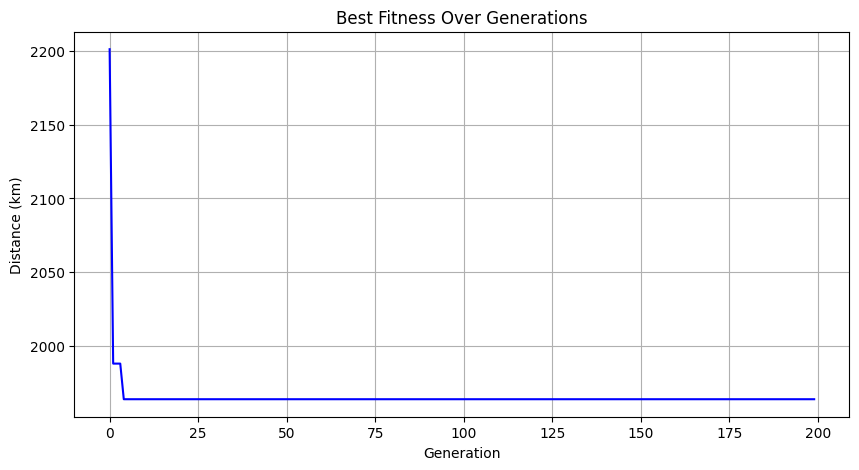


Best Route Found:
Fes -> Meknes -> Marrakech -> Agadir -> Casablanca -> Rabat -> Kenitra -> Tangier -> Tetouan -> Oujda
Total Distance: 1963.77 km


In [10]:
# Get best route
best_route = min(population, key=lambda x: x.fitness)

# Plot fitness progress
plot_fitness_progress(best_fitness_history)

# Create and display route map
create_route_map(best_route)

# Print final route
print("\nBest Route Found:")
print(" -> ".join([city.name for city in best_route.path]))
print(f"Total Distance: {best_route.fitness:.2f} km")